In [ ]:
!unzip brain_pictures.zip

Archive:  brain_pictures.zip
  inflating: Testing/glioma_tumor/image(1).jpg  
  inflating: Testing/glioma_tumor/image(10).jpg  
  inflating: Testing/glioma_tumor/image(100).jpg  
  inflating: Testing/glioma_tumor/image(11).jpg  
  inflating: Testing/glioma_tumor/image(12).jpg  
  inflating: Testing/glioma_tumor/image(13).jpg  
  inflating: Testing/glioma_tumor/image(14).jpg  
  inflating: Testing/glioma_tumor/image(15).jpg  
  inflating: Testing/glioma_tumor/image(16).jpg  
  inflating: Testing/glioma_tumor/image(17).jpg  
  inflating: Testing/glioma_tumor/image(18).jpg  
  inflating: Testing/glioma_tumor/image(19).jpg  
  inflating: Testing/glioma_tumor/image(2).jpg  
  inflating: Testing/glioma_tumor/image(20).jpg  
  inflating: Testing/glioma_tumor/image(21).jpg  
  inflating: Testing/glioma_tumor/image(22).jpg  
  inflating: Testing/glioma_tumor/image(23).jpg  
  inflating: Testing/glioma_tumor/image(24).jpg  
  inflating: Testing/glioma_tumor/image(25).jpg  
  inflating: Testing/g

# 0) Introduction ?

Ce document est inspiré de:

https://www.kaggle.com/code/alsaniipe/brain-tumor-classification-with-custom-cnn/notebook

Il avait pour objectif d'expliquer à mes collègues, de manière humoristique, comment utiliser scikit-learn et tensorflow pour creer un modèle de machine learning. Le but n'etant pas d'avoir un bon modele, mais plutot une explication des concepts mis en jeu.

Pour les 0 personnes extérieures qui liront ce document. Deja, bonjour et ensuite, bonne lecture :)

-----------------------------------------------------------------------------------------

Google a developpé en 2015 un framework open-source pour le machine learning "Tensorflow" rendu open-source par la suite.

Pour ce travail, je vais utiliser Tensorflow et Keras qui est une bibliothèque haut-niveau pour faire du machine learning. Il contient tous les elements necessaires pour faire le preprocessing, des modeles personnalisés et plein d'autres choses !

Par chance, Keras implémente troix reseaux de neurones convolutifs (CNN) de type "Densenet":

- Le densenet 131
- Le densenet 169
- Le densenet 201

Le nombre, c'est pas le nombre de protons dans le noyaux.. vous confondez avec vos cours de Chimie. La difference entre les nombres réside dans le nombre de "couches" utilisées dans le réseau de neurones. Une "couche" correspond à une unité de traitement qui possède plusieurs neurones. Chaque couche est reliée aux precedentes.

Nous verrons plus tard quelles couches seront utilisées et ajoutées dans le réseau.

# 1) Chargement des bibliothèques necessaires

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical,plot_model

import numpy as np
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
print(tf.__version__)

2.16.1


# 2) Chargement des fichiers

Bon, c'est la partie evidente où l'on charge les données d'entrainement et de test pour pouvoir les traiter. C'est facile mais il y a quand même quelques subtilités:

In [ ]:
#Le dossier de train avec ses sous-dossiers
train_path = "./brain_pictures/Training/"

#Le dossier de test avec ses sous-dossiers
test_path = "./brain_pictures/Testing/"

On est prèt à charger les données d'entrainement maintenant !
Cela se fait grace à la fonction "flow_from_directory" de Keras.

Il faut utiliser une instance de"ImageDataGenerator" qui permet d'effectuer des traitements sur les images importées.



In [ ]:
#Creer un generateur de données. On n'a pas encore chargé les données ici, on a juste défini ceetaines reglès à utiliser.
train_generator = ImageDataGenerator(rescale=1./255,
                                              shear_range = 0.2,
                                              zoom_range = 0.2,
                                              horizontal_flip = True,
                                              vertical_flip= True,
                                              width_shift_range=0.3,
                                              fill_mode = "nearest")


D'accord, mais moi je ne comprends pas les paramètres que tu passes dans le ImageDataGenerator !

L'idée lors de l'importation des données de tests... est d'importer les données de tests. Bien joué !

Mais on fait mieux que ca! On va faire ce qui s'appelle de l'**augmentation des données**. On va creer "artificiellement" des données d'entrées pour la machine. En fait, on utilise les images deja existantes sur lesquelles on effectue des traitements (zoom / resize / roatation etc..) pour aider l'ordinateur à mieux faire face à certaines images qu'il ne connait pas.

Cela permet aussi de limiter le "**surapprentissage**": le fait que l'ordinateur apprenne trop bien les caractéristiques des données d'entrée. Et ceci, à tel point qu'il n'arrive pas à analyser des nouvelles images, car au lieu d'apprendre à reconnaitre les caractéristiques de l'image (comme la position d'une cellule cancéreuse sur le cerveau), il apprend des données comme le [bruit](https://fr.wikipedia.org/wiki/Bruit_num%C3%A9rique) de l'image par exemple.

En bref, on augmente les données pour aider à réduire le risque de surapprentissage en exposant le modèle à une plus grande variété de données, ce qui permet au modèle de mieux apprendre à reconnaître les motifs importants et à être plus robuste face aux variations dans les données de test.

In [ ]:
#Même chose pour les données de test

test_generator = ImageDataGenerator(rescale=1./255)

On applique aussi une normalisation des pixels. Je pense que vous savez que les pixels sont encodés en RGB, une valeur de rouge, bleu et vert sur 256 valeurs (0-255) chacune. Diviser les valeurs par 255 permet de travailler avec des valeurs de couleurs entre  [0-1] et donc de réduire les variations de couleurs. On travaille avec des fonctions mathématiques, donc pour l'ordinateur, une comparaison entre une valeur de vert de 17 et une valeur de vert de 255 et beaucoup plus significative qu'une variation de 0.07 (17/255) et 1.

In [ ]:
batch_size = 64 # Le nombre d'echantillons utilisées lors d'un traitement (on ne traite pas toutes les données d'un coup)
image_size = 224 #Le modele densent travaille avec des images de 224x224.

In [ ]:
train_data = train_generator.flow_from_directory(
    batch_size = batch_size, #La taille d'un échantillon
    directory = train_path, #Le répertoire des données
    target_size = (image_size, image_size), #La taille de l'image (largeur / hauteur)
    class_mode = "categorical" #Les données sont categoriques (no_tumor / glioma_tumor etc...)
)

Found 2870 images belonging to 4 classes.


In [ ]:
test_data = test_generator.flow_from_directory(
    batch_size = batch_size,
    directory = test_path,
    target_size = (image_size, image_size),
    class_mode = "categorical"
)

Found 394 images belonging to 4 classes.


Et c'est magique ! Car on a précisé que nos données sont catégoriques et que nos données sont rangées dans des sous-dossiers contenant leurs catégories respectives, Keras a automatiquement determiné les 4 classes qu'il va utiliser lors des prédictions.

In [ ]:
classes = np.array(train_data.classes)
print("Les classes traitées par Keras:")
print(classes)
print()


#On a 0, 1, 2 et 3. On mappe donc les valeurs numériques  (label encoding inversé)
labels = {
    0: "Glioma",
    1: "Meningioma",
    2: "No Tumor",
    3: "Pituitary"
}

# On recupère les noms des catégories par rapport aux nombres
noms_categories = np.vectorize(labels.get)(classes)


# On compte et affiche les elements uniques avec numpy
categories, comptes = np.unique(noms_categories, return_counts=True)
for cat, n in zip(categories, comptes):
    print(f"Il y a {n} éléments dans la catégorie '{cat}'.")

def getClassName(numClass):
  return labels.get(numClass)

Les classes traitées par Keras:
[0 0 0 ... 3 3 3]

Il y a 826 éléments dans la catégorie 'Glioma'.
Il y a 822 éléments dans la catégorie 'Meningioma'.
Il y a 395 éléments dans la catégorie 'No Tumor'.
Il y a 827 éléments dans la catégorie 'Pituitary'.


# 3) Importation du modèle densenet

Comme énoncé dans l'introduction, Keras est fourni avec des modèles pré-entrainés. L'entrainement s'effectue sur la base de données ImageNet qui contient quand même quelques images (14M d'images).

Dans un premier temps, et pour gagner du temps de traitement, on va utiliser le modèle tel que fourni, c'est à dire sans le ré-entrainer. Faut bien voir ce que ca donne...

In [ ]:
densenet = tf.keras.applications.DenseNet201(
    include_top=False,
    weights="imagenet",
    pooling=None,
    input_shape=(224,224,3)
)

Et voila ! Les données sont téléchargées. Encore une fois, c'est quoi ces paramètres ?

- **include_top**:<br>
Cela correspond au fait que l'on inclue pas la tête de modèle, c'est à dire la **dernière couche** du modèle. Elle est tres importante car elle permet notamment de faire la classification finale. Modifier cette couche permet aussi de faire du fine-tuning, c'est à dire adapter le modèle aux données d'entrée, en l'occurance ici de magnifiques photos (pas flippantes du tout...) de cerveaux humains.

- **weights**:<br>
On utilise les poids optimisés sur la BDD Imagenet

- **pooling**:<br>
Le pooling ça à l'air un peu compliqué. De ce que j'ai compris, cela permet de réduire la "dimensionalité des données". Par exempe, cela permet de reduite une matrice de pixels de 9x9 en 6x6, réduisant la taille des données traitées et allège en conséquence le temps de traitement.

- **input_shape**:<br>
Bon, je vous laisse deviner pour celle là. Attention, c'est dur !

In [ ]:
#On désactive l'apprentissage. On estime que le modèle sera performant sur nos données
for layer in densenet.layers:
    layer.trainable= False

Keras divise les couches en deux types, les "inputs" (couches du bas) et les "outputs" (couche du haut).

Il faut donc fournir les couches du haut et du bas pour pouvoir faire le modèle.

Souvenons nous que nous avons supprimé la dernière couche de traitement du réseau. Il faut maintenant la recréer manuellement. Et c'est là qu'il est vraiment possible de customiser comment vont être classées nos données !

In [ ]:
def createOutput(bottom_model, num_class, D=64):
    top_model= bottom_model.output
    top_model= Flatten(name="flatten") (top_model)
    top_model= Dense(D, activation="relu") (top_model)
    top_model= Dropout(0.2) (top_model)
    top_model= Dense(num_class, activation="softmax") (top_model)
    return top_model

A consulter: https://stanford.edu/~shervine/l/fr/teaching/cs-230/pense-bete-reseaux-neurones-convolutionnels

1) On recupere les couche de sorties du modele densenet.

2) On effectue une transformation de dimensions. La sortie recupérée precedemment sera applatie, c'est à dire réduite en un vecteur à une dimension.

3) On ajoute une nouvelle couche avec un nombre de neurones défini: ici 64 par défaut. Une couche dense est une couche dans laquelle tous les neurones sont reliés a tous les neurones des couches précédentes.
Cette couche utilise la fonction ReLu (et pas relou, ajoutez pas de o par pitié):

\begin{align*}
\text{ReLU}(x) = \max(0, x)
\end{align*}

Une fonction d'activation est une fonction mathématique appliquée à la sortie d'un neurone d'un réseau de neurones. Elle introduit de la non-linéarité dans le modèle, ce qui permet au réseau de capturer des relations non linéaires entre les variables d'entrée et de sortie. Sans fonction d'activation, les couches de neurones successives ne seraient que des transformations linéaires les unes des autres, et le modèle serait incapable d'apprendre des représentations complexes des données.

Ici on utilise la fonction ReLu qui est la plus utilisée mais il en existe d'autres:

\begin{align*}
\text{Sigmoid} &: f(x) = \frac{1}{1 + e^{-x}} \\
\text{Tanh (tangente hyperbolique)} &: f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} \\
\text{Softmax} &: f(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}
\end{align*}


Les étapes 2 et 3 sont représentées ci dessous:

![/content/DenseLayer.png](https://stanford.edu/~shervine/teaching/cs-230/illustrations/fully-connected-ltr.png?32caf9e07c79d652faa292812579d063)

4) Une couche de régularisation est ajoutée.Cette couche permet de réduire le suraprentissage, le faire généraliser davantage. Cette couche permet de désactiver un certain nombre de pourcentage des neurones de la couche précédente.

5) Une dernière couche Dense est ajoutée qui utilise la fonction "softmax" pour produire des probalité sur les classes. Le nombre de classes est fourni avec le paramètre "num_class". La classe avec la probabilité la plus élevée à la fin du traitement sera choisie comme prédiction finale du modèle.

Et voila ! On peut maintenant proceder à la création du modèle: Keras va créer un objet contenant l'architecture du modèle, c'est à dire toutes les couches utilisées.



In [ ]:
num_classes = 4 #On a 4 classes

output = createOutput(densenet, num_classes) #On crée l'output, les couches du haut

model = Model(inputs= densenet.input, outputs = output) #On utilise les inputs du modlee pré-entrainé, et notre output custom !

Puis on compile.
On fournit 3 paramètres:

- **La fonction de perte.** C'est une fonction mathématique que l'on utilise pour évaluer les performances d'un traitement. On cherche à minimiser cette fonction.
On utilise ici [l'entropie croisée](https://fr.wikipedia.org/wiki/Entropie_crois%C3%A9e). Alors me demandez pas la théorie derrière, je suis informaticien moi, pas mathématicien... mais il est courant de l'utiliser🤷‍♂️.

- **Une fonction d'optimisation.** Ici on utilise la fonction d'Adam (je cherche toujours Eve mais impossible de la trouver), qui est une généralisation de la descente de Gradient.

- **Les metrics.** C'est une fonction d'évaluation. Ici nous travaillons avec un problème de classification multi-classes donc on utilise l'indicateur "accuracy" pour évaluer la justesse de nos prédictions.

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 24,343,428 (92.86 MB)

 Trainable params: 6,021,444 (22.97 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer= Adam(learning_rate=0.0001),
              metrics= ['accuracy'])

Bon, c'est bientôt fini, mais il y a encore un truc un comprendre... les fonctions de rappels (callbacks) !

Ce sont des fonctions qui vont être appelées au cours du processus de traitement et qui vont permettre de prendre des décisions.



In [ ]:
checkpoint = ModelCheckpoint("/mes_modèles/densenet_brain.keras",
                            monitor= "val_loss",
                            mode= "min",
                            save_best_only= True,
                            verbose=1)

earlystop = EarlyStopping(monitor= "val_loss",
                         min_delta= 0,
                         patience= 10,
                         verbose=1,
                         restore_best_weights= True)


reduce_lr = ReduceLROnPlateau(monitor= "val_loss",
                         factor=0.1,
                         patience= 5,
                         verbose=1,
                         min_delta= 0.00001)


callbacks=[earlystop, checkpoint, reduce_lr]

1) **ModelCheckpoint**:<br>
Ce rappel sauvegarde le modèle à chaque epoch (itération) où la performance sur l'ensemble de validation (val_loss) est la meilleure en utilisant la fonction de perte.

2) **EarlyStopping**:<br>
Ce rappel arrête l'entraînement lorsque la performance du modèle sur l'ensemble de validation cesse de s'améliorer en utilisant la fonction de perte. On vérifie  ici 10 epochs avant d'arrêter le traitement après que l'amélioration a cessé (quand la fonction de perte a convergé).

3) **ReduceLROnPlateau**:<br>
Ce rappel réduit le taux d'apprentissage (learning rate = LR) lorsque la performance du modèle cesse de s'améliorer. On attend 5 epochs, et un changement de variation maximal de 0.00001 pour réduire le taux d'apprentissage.

------------

C'est le moment qu'on attend tous: faire exploser les ventilos de sa carte graphiques. Youpi !

Plus sérieusement, une fois que tous ces trucs obscures ont été délibéremment copiés-collés d'internet (tel un vrai developpeur), je veux dire codés, on peut fit le modèle.

On fournit le nombre d'images et le nombre d'epochs (un epoch est complété quand toutes les images ont été traitées au moins une fois) et le batch_size.

Au lieu d'apprendre betement en utilisant toutes les images à notre disposition, on divise nos images en plusieurs échantillons que l'on traite individuellement. Chaque échantillon permet d'avoir un impact sur les poids qui relient les neurones de nos couches denses.

On a ainsi des traitements plus légers et moins de mémoire utilisé.

![epoch and batch](https://datascientest.com/wp-content/uploads/2022/11/batch-vs-epoch.png)

In [ ]:
nb_train_samples= 2870 # Nombre d'images dans les données d'entrainement
nb_validation_samples= 394 # Nombre d'images dans les données test
epochs = 32 # Nombre d'itérations
batch_size = 64 # Batch size

history= model.fit(train_data,
                   steps_per_epoch = nb_train_samples//batch_size,
                   epochs = epochs,
                   callbacks = callbacks,
                   validation_data = test_data,
                   validation_steps = nb_validation_samples // batch_size,
                   shuffle= True)

Epoch 1/32
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4625 - loss: 1.4381
Epoch 1: val_loss improved from inf to 1.34392, saving model to /mes_modèles/densenet_brain.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4649 - loss: 1.4298 - val_accuracy: 0.5260 - val_loss: 1.3439 - learning_rate: 1.0000e-04
Epoch 2/32
 1/44 ━━━━━━━━━━━━━━━━━━━━ 12s 296ms/step - accuracy: 0.6719 - loss: 0.8112
Epoch 2: val_loss did not improve from 1.34392
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.6719 - loss: 0.8112 - val_accuracy: 0.5000 - val_loss: 1.4250 - learning_rate: 1.0000e-04
Epoch 3/32
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.7479 - loss: 0.6599
Epoch 3: val_loss improved from 1.34392 to 1.29396, saving model to /mes_modèles/densenet_brain.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 47s 882ms/step - accuracy: 0.7481 - loss: 0.6592 - val_accuracy: 0.5521 - val_loss: 1.2940 - learning_rate: 1.0000e-04
Epoch 4/32
 1/44 ━━━━━━━━━━━━━━━━━━━━ 12s 282ms/step - accura

In [ ]:
model.save('./densenet201_basic.h5')

# 4) Visualisation des résultats

Maintenant que le modèle a été crée, on peut visualiser la précision des des prédictions.

On utilise ici deux indicateurs:
- la perte en orange (training_loss)
- l'accuracy en bleu --> le nombre de bonnes prédictions sur le nombre total d'images.

In [ ]:
import numpy as np

def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])

    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])

    epochs= range(len(history.history['loss']))

    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))

    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')

    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)

    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)

    ax1.legend()

    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')

    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)

    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)

    ax2.legend()

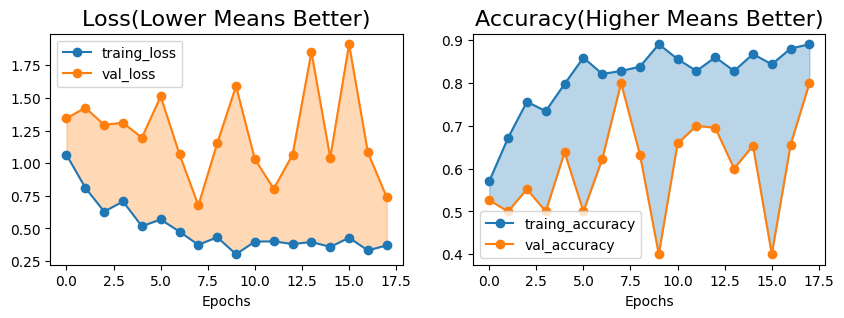

In [ ]:
plot_training_curves(history)

On constate sur ce graphique deux choses.
Premeirement, les courbes, ont dirait des montagnes. Et c'est pas une bonne chose... Est-ce que ca veut dire que j'ai fait que des betises et que ca n'a pas fonctionné ? Pas reelement.

Ces pics signifient une chose: le modèle a appris, mais mal ! On a divisé nos données initiales pour permettre d'avoir des données de test. Lors de l'apprentissage, le modele relaise des preidctiosn et compare ces prédictions aux données que l'on connait. C'est la courbe bleue. On voit que le modele est performant sur les données d'entrainement.

En revanche, pour les données qu'il ne connait pas, le modèle est très indécis. Parfois il prédit bien, parfois il prédit tres mal.

Cela signifie probablement que le modèle a sur-appris, malgré nos précuations.
Overfitting.

On pourrait résoudre ce probleme en modifiant le pré-traitement pour qu'il soit plus efficace ou modifier le modèle...

Et c'est là tout le but du data-scientist: trouver la manière la plus optimale de faire apprendre à l'ordinateur les relations entre les données.

# 5) Prédiction sur des données des de test.

La partie la plus longue du processus à été effectué: le modèle est entrainé spécifiquement pour ce problème de classification d'images de cerveaux.

Chargeons une image au hasard et vérifions que la prédiction est correcte.

In [ ]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img= image.load_img("./brain_pictures/Testing/glioma_tumor/image(10).jpg",target_size=(224,224))

# Convert image to array of pixels
x = image.img_to_array(img)

# Normalize the pixels
x = x/255
x = np.expand_dims(x, axis=0)

# Preprocess data automatically for the image
img_data = preprocess_input(x)
img_data.shape

# Use our trained model to do a prediction of the image.
preds = model.predict(x)

# On récupère la valeur maximale de la prédiction: c'est le numéro de la class prédite !
preds = np.argmax(preds, axis=1)

# Et enfin, on affiche le nom de la classe
print(getClassName(preds[0]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
Glioma
